## Dependencias

## Dependencias 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

## Cargar Datos

In [2]:
data = pd.read_sas('../data/churn.sas7bdat')
data.shape

(2801, 14)

In [3]:
data.head()

,V_ACCT_LGHT,C_IP,C_VMP,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS,TARGET,ID
0,128.0,b'No',b'Yes',25.0,45.07,99.0,16.78,91.0,11.01,3.0,2.70,1.0,0.0,1.0
1,107.0,b'No',b'Yes',26.0,27.47,103.0,16.62,103.0,11.45,3.0,3.70,1.0,0.0,2.0
2,137.0,b'No',b'No',0.0,41.38,110.0,10.30,104.0,7.32,5.0,3.29,0.0,0.0,3.0
3,65.0,b'No',b'No',0.0,21.95,83.0,19.42,111.0,9.40,6.0,3.43,4.0,1.0,11.0
4,168.0,b'No',b'No',0.0,21.90,71.0,8.92,128.0,6.35,2.0,3.02,1.0,0.0,13.0


## Partición

In [4]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
train.shape, valid.shape

((1960, 14), (841, 14))

## Naturaleza de variables 

In [ ]:
um = ['ID']
varc = [v for v in data.columns if v[:2]=='V_']
#vard = [v for v in data.columns if v[:2]=='C_']
vart = ['TARGET']
len(varc)#,len(vard)

(10, 2)

## Aprendizaje 

In [68]:
mod = MLPClassifier(hidden_layer_sizes=(2,), activation='tanh',learning_rate='invscaling',solver='sgd',max_iter=10000)

In [69]:
X = train[varc].copy()
sc = MinMaxScaler()
sc.fit(X)
Xs = pd.DataFrame(sc.transform(X),columns=X.columns)

In [70]:
mod.fit(Xs, train[vart[0]])

MLPClassifier(activation='tanh', hidden_layer_sizes=(2,),
              learning_rate='invscaling', max_iter=10000, solver='sgd')

## Pesos de la red $\vec{\theta}$

In [71]:
[w.shape for w in mod.coefs_]

[(10, 2), (2, 1)]

In [72]:
train['proba'] = mod.predict_proba(sc.transform(train[varc]))[:,1]
valid['proba'] = mod.predict_proba(sc.transform(valid[varc]))[:,1]

/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [73]:
print('AUC train:',roc_auc_score(train[vart[0]],mod.predict_proba(sc.transform(train[varc]))[:,1]))
print('AUC valid:',roc_auc_score(valid[vart[0]],mod.predict_proba(sc.transform(valid[varc]))[:,1]))

AUC train: 0.5679395521617561
AUC valid: 0.5642897091722595


/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


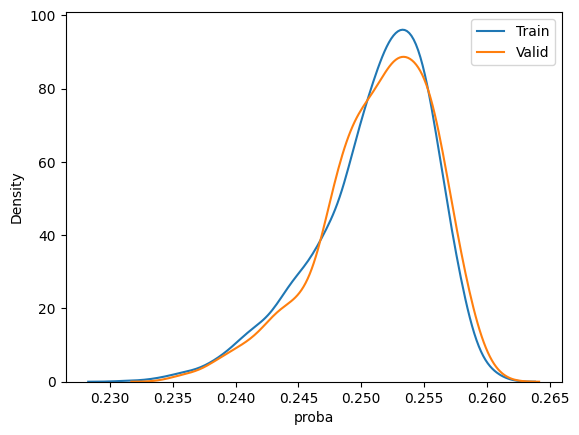

In [74]:
sns.kdeplot(train['proba'], label='Train')
sns.kdeplot(valid['proba'], label='Valid')
plt.legend()

In [75]:
train['r_proba'] =pd.cut(train['proba'], bins=np.arange(0,1.2,0.2), include_lowest=True).astype(str)
valid['r_proba'] =pd.cut(valid['proba'], bins=np.arange(0,1.2,0.2), include_lowest=True).astype(str)

In [76]:
cubo_train = train[['r_proba']+vart+um].groupby(['r_proba']+vart).count().reset_index().assign(muestra='train')
cubo_valid = valid[['r_proba']+vart+um].groupby(['r_proba']+vart).count().reset_index().assign(muestra='valid')

In [77]:
cubo = pd.concat([cubo_train,cubo_valid],ignore_index=True)

In [78]:
cubo.to_clipboard(index=False)